## Load Twitter API and some useful functions

In [1]:
import tweepy 
import csv
import json
import re
import datetime

#load twitter credentials from file 
with open('twitter_credentials.json') as cred_data:
    info = json.load(cred_data)
    consumer_key = info['CONSUMER_KEY']
    consumer_secret = info['CONSUMER_SECRET']
    access_key = info['ACCESS_KEY']
    access_secret = info['ACCESS_SECRET']

#save authentication info 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth)

In [2]:
#function to clean up the text of tweet 
def clean_tweet(tweet): 
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) (\w+:\/\/\S+)", " ", tweet).split())

In [3]:
#simpler function to get tweets, doesnt work? 
def get_tweets_simple(query, max_tweets):
    searched_tweets = [status for status in tweepy.Cursor(api.search, q=query).items(max_tweets)]
    tweets = []
    for tweet in searched_tweets:
        # empty dictionary to store required params of a tweet 
        parsed_tweet = {}
        # saving text of tweet 
        parsed_tweet['text'] = clean_tweet(tweet.text)
        tweets.append(parsed_tweet)

In [4]:
#more complicated function to download tweets for given query
def get_tweets(query, max_tweets):
    searched_tweets = []
    last_id = -1
    while len(searched_tweets) < max_tweets:
        count = max_tweets - len(searched_tweets)
        try:
            new_tweets = api.search(q = query, count = count, max_id = str(last_id - 1))
            if not new_tweets:
                break
            searched_tweets.extend(new_tweets)
            last_id = new_tweets[-1].id
        except tweepy.TweepError as e:
        # depending on TweepError.code, one may want to retry or wait
        # to keep things simple, we will give up on an error
            break
            
    tweets = []
    for tweet in searched_tweets:
        # empty dictionary to store required params of a tweet 
        parsed_tweet = {}
        # saving text of tweet 
        parsed_tweet['text'] = clean_tweet(tweet.text)
        tweets.append(parsed_tweet)
            
    return tweets

In [5]:
#return all tweets from given screenname
def get_tweets_user(screen_name, max_tweets, startDate, endDate):
    searched_tweets = []
    last_id = -1
    while len(searched_tweets) < max_tweets:
        count = max_tweets - len(searched_tweets)
        try:
            #new_tweets = api.user_timeline(id = screenname, count = count, max_id = str(last_id - 1))
            new_tweets = api.user_timeline(screen_name = screen_name, count = max_tweets, include_rts = True)
            if not new_tweets:
                break
            searched_tweets.extend(new_tweets)
            last_id = new_tweets[-1].id
        except tweepy.TweepError as e:
        # depending on TweepError.code, one may want to retry or wait
        # to keep things simple, we will give up on an error
            break
            
    tweets = []
    for tweet in searched_tweets:
        if tweet.created_at < endDate and tweet.created_at > startDate:   
            # empty dictionary to store required params of a tweet 
            parsed_tweet = {}
            # saving text of tweet 
            parsed_tweet['text'] = clean_tweet(tweet.text)
            parsed_tweet['datetime'] = tweet.created_at
            tweets.append(parsed_tweet)
            
    return tweets

## Load Quandl stock data

In [6]:
import pandas as pd
import quandl
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/derek/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['info']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
start_date = datetime.datetime(2015,1,1) # Beginning of period 
end_date = datetime.datetime(2016,1,1) # End of period 
stock = "TSLA" # some stock label we are interested in
tesla = quandl.get("WIKI/" + stock, start_date=start_date, end_date=end_date) #download data with quandl

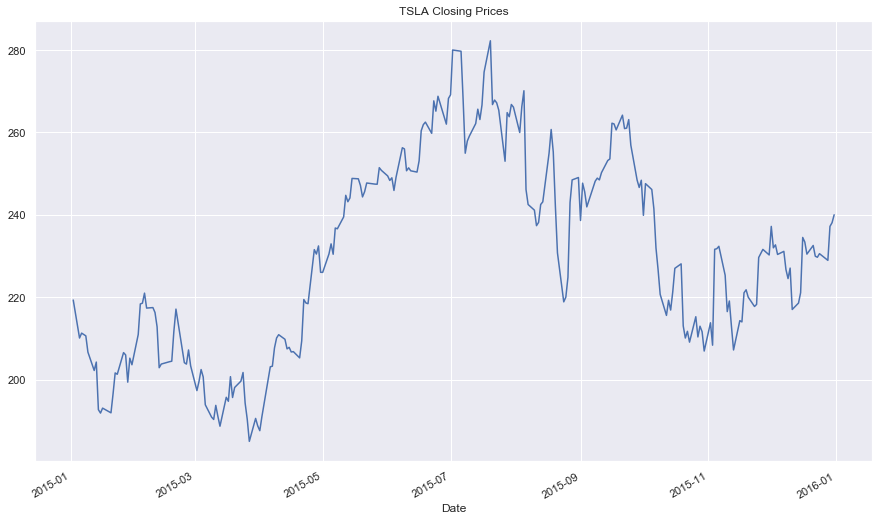

In [8]:
pylab.rcParams['figure.figsize'] = (15, 9)
plt.title(stock + " Closing Prices")
tesla["Close"].plot() # plot daily closing prices 
plt.show()

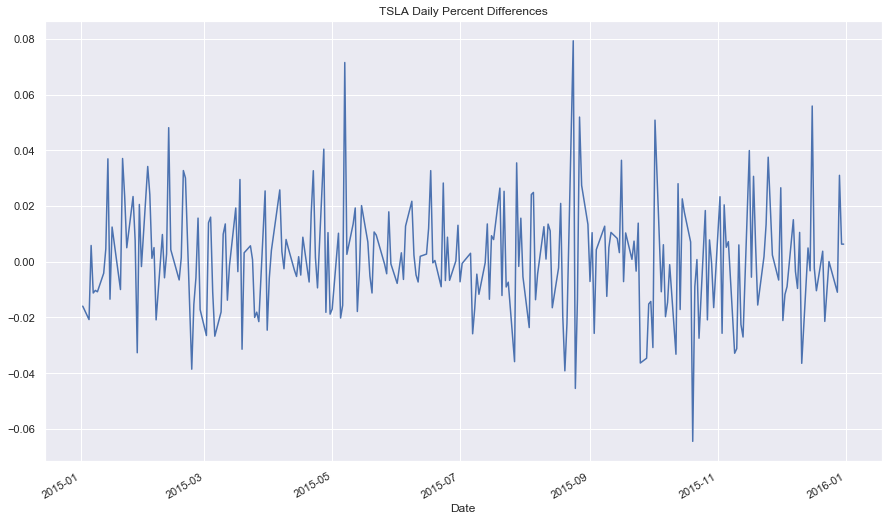

In [29]:
tesla["DailyPercentDiff"] = (tesla["Close"] - tesla["Open"]) / tesla["Open"]
plt.title(stock + " Daily Percent Differences")
tesla["DailyPercentDiff"].plot() # plot daily closing prices 
plt.show()

## Proof of Principle : Do Barack Obama's tweets effect TSLA closing prices?

In [30]:
start_date = datetime.datetime(2015,1,1) # Beginning of period 
end_date = datetime.datetime(2016,1,1) # End of period 
stock = "TSLA" # some stock label we are interested in
tesla = quandl.get("WIKI/" + stock, start_date=start_date, end_date=end_date) #download data with quandl

In [31]:
baracks_tweets = get_tweets_user('BarackObama', 1000, start_date, end_date)